# Controllers

This notebook will demonstrate the basic workflow for controllers.

## Set-Up

First we will import AutoMPC and generate our system identification dataset as before.

In [1]:
import autompc as ampc
import numpy as np
from autompc.benchmarks import CartpoleSwingupBenchmark

benchmark = CartpoleSwingupBenchmark(data_gen_method='random_walk')

system = benchmark.system
trajs = benchmark.gen_trajs(seed=100, n_trajs=100, traj_len=200)
test_trajs = benchmark.gen_trajs(seed=101, n_trajs=100, traj_len=200)
print("Observations:",system.observations)

Loading AutoMPC...
Finished loading AutoMPC
Observations: ['theta', 'omega', 'x', 'dx']


Next, we will create a System ID model to be used by the controller.  Here, we will use the SINDy model.  Because SINDy has enough basis functions to capture the true behavior of the dynamics, the RMSE is very low.

MLP 1-step RMSE on training set: 5.911957768349087e-14
MLP 1-step RMSE on testing set: 5.873496960719795e-14


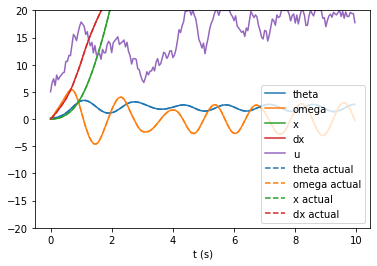

In [2]:
from autompc.sysid import SINDy

model = SINDy(system, allow_cross_terms=True)
model.set_hyper_values(trig_basis='true', trig_interaction='true')
model.train(trajs)

%matplotlib inline
import matplotlib.pyplot as plt
from autompc.sysid.metrics import get_model_rmse
from autompc.graphs import plot_rollout,plot_traj,plot_trajs

print("MLP 1-step RMSE on training set:",get_model_rmse(model,trajs))
print("MLP 1-step RMSE on testing set:",get_model_rmse(model,test_trajs))

plot_rollout(trajs[0],model)
plt.ylim([-20,20])
plt.show()

## Creating the Control Problem (OCP)

To create a controller, we first need to define the optimal control problem (OCP).  The OCP specifies an objective function and a set of constraints.

We'll start out by defining the objective function, which will be a quadratic cost.  Here we'll manually set some values for the cost matrices which have been shown in the past to work well, but in the future we'll learn how to choose these automatically via tuning (see [TODO] for details).

In [3]:
from autompc.costs import QuadCost

Q = np.diag([1.0, 0.001, 0.001, 0.1])
R = np.diag([0.001])
F = np.diag([1000, 10, 0.001, 10])
cost = QuadCost(system, Q, R, F, goal=np.zeros(4))

Now, we create the OCP and associate it with hte cost we just created.  We'll also add constraints in the form of control bounds.  AutoMPC doesn't currently support more complex constraints than this, but we're hoping to add to support for these in the future!

In [4]:
from autompc.ocp import OCP

ocp = OCP(system)
ocp.set_cost(cost)
ocp.set_ctrl_bound("u", -20.0, 20.0)

## Controller

Now, let's create the controller.

In [5]:
controller = ampc.Controller(system)

To use the controller, there are a few things we need to set up.  First, let's set the optimizer.  Here will use IterativeLQR with a horizon of 20.

In [6]:
from autompc.optim import IterativeLQR

controller.set_optimizer(IterativeLQR(system))
controller.set_optimizer_hyper_values(horizon=20)
controller.set_optimizer_hyper_values(max_iter=20)
controller.set_optimizer_hyper_values(frequency=1)

Next, we will set the controller to use the system ID model.

In [7]:
controller.set_model(model)

Next, we will provide the controller with the OCP we created earlier.

In [8]:
controller.set_ocp(ocp)

Finally, we need to call `build()` to get the controller ready to use.

In [9]:
controller.get_config_space()

Checking compatibility with OCP
Quad cost
['Identity']


Configuration space object:
  Hyperparameters:
    IterativeLQR:frequency, Type: UniformInteger, Range: [1, 5], Default: 1
    IterativeLQR:horizon, Type: UniformInteger, Range: [5, 25], Default: 20
    IterativeLQR:max_iter, Type: UniformInteger, Range: [10, 50], Default: 20
    SINDy:poly_basis, Type: Categorical, Choices: {true, false}, Default: false
    SINDy:poly_cross_terms, Type: Categorical, Choices: {true, false}, Default: false
    SINDy:poly_degree, Type: UniformInteger, Range: [2, 8], Default: 3
    SINDy:threshold, Type: UniformFloat, Range: [1e-05, 10.0], Default: 0.01, on log-scale
    SINDy:time_mode, Type: Categorical, Choices: {discrete, continuous}, Default: discrete
    SINDy:trig_basis, Type: Categorical, Choices: {true, false}, Default: false
    SINDy:trig_freq, Type: UniformInteger, Range: [1, 8], Default: 1
    SINDy:trig_interaction, Type: Categorical, Choices: {true, false}, Default: false
    constraint_transformer, Type: Categorical, Choices: {_}, Default:

In [10]:
controller.build()

We can now use the controller!  This is done by calling the `step` method with the most recent observation. 

Here we can also examine the optimized trajectory using the `IterativeLQR.get_traj()` method.

Optimized control: [-10.52982601]


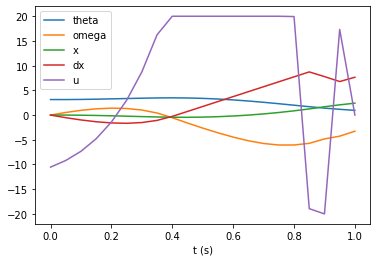

In [11]:
current_obs = np.array([np.pi, 0.0, 0.0, 0.0])
controller.reset()
u = controller.step(current_obs)
print("Optimized control:",u)
plot_traj(controller.optimizer.get_traj())
plt.show()

We note that the controller tracks state for both the optimizer and the model.  This means calling the controller for the same observation may not yield the same result.

We can always reset to the initial state by calling `reset()`, or explicitly manage the state using the `set_state()` and `get_state()` methods.

By repeatedly calling run, we can simulate the behavior of the controller. To make this easier, we provide the `simulate` function.  Since we have the ground truth dynamics of the system available, we will just use that here.

In [12]:
controller.reset()
traj = ampc.simulate(controller, init_obs=np.array([np.pi, 0.0, 0.0, 0.0]), max_steps=100, dynamics=benchmark.dynamics)

 99%|█████████▉| 99/100 [00:47<00:00,  2.07it/s]


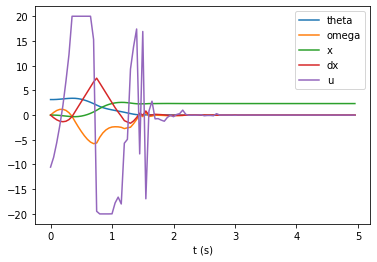

In [13]:
plot_traj(traj)

We can visualize the resulting trajectory using the animation helper in the benchmark problem.

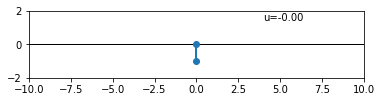

In [14]:
import matplotlib.pyplot as plt
from IPython.display import HTML

fig = plt.figure()
ax = fig.gca()
anim = benchmark.visualize(fig, ax, traj)
HTML(anim.to_html5_video())

More generically, we can use the standard AutoMPC plotting functions to examine controller performance.  On the left we'll plot the trajectory as shown above, and on the right we'll plot the statistics of handful of trajectories starting from varying initial angles of the cartpole system.  (**Note**: because each rollout simulates an MPC controller running iLQR, this will take several minutes, depending on your hardware.)

 99%|█████████▉| 99/100 [00:44<00:00,  2.22it/s]


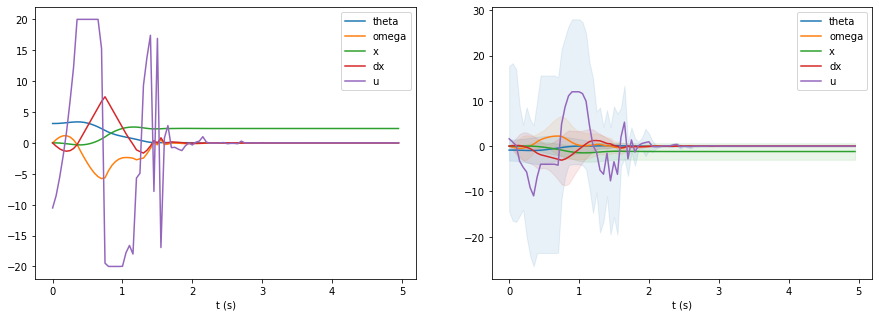

In [15]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
plot_traj(traj,ax=ax1)
simulated_trajs = []
for i in range(5):
    init_state = np.array([np.random.uniform(-np.pi,np.pi),0,0,0])
    controller.reset()
    traji = ampc.simulate(controller, init_obs=init_state, max_steps=100, dynamics=benchmark.dynamics)
    simulated_trajs.append(traji)
plot_trajs(simulated_trajs,ax=ax2)
plt.show()

We can compare the iLQR-based controller to a more naive controller, such as one that uses classical LQR. To construct LQR, we will need to pass in a linear dynamics model, so we will linearize the SINDy model about the upright pose (origin).  We'll then build the controller and simulate it as before.

(Note this computation goes by by much more quickly, since LQR is a much simpler controller that does not perform any optimization.  This is the type of tradeoff that a control designer must grapple with when designing a controller -- AutoMPC is designed to make these tradeoffs automatically!)

Linearized model
A= [[1.   0.05 0.   0.  ]
 [0.49 0.95 0.   0.  ]
 [0.   0.   1.   0.05]
 [0.   0.   0.   1.  ]]
B= [[0.  ]
 [0.1 ]
 [0.  ]
 [0.05]]
 99%|█████████▉| 99/100 [00:00<00:00, 15124.79it/s]


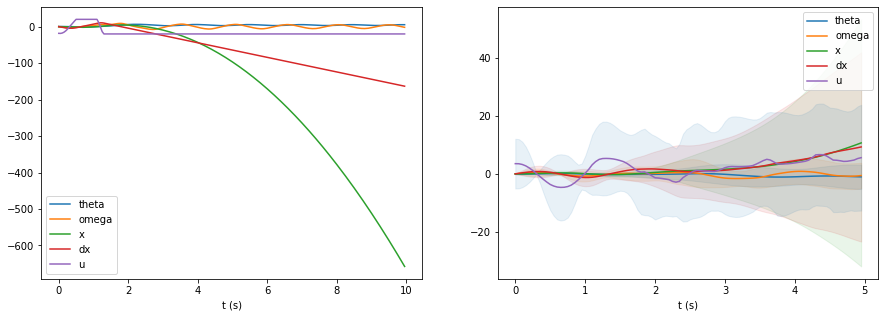

In [16]:
from autompc.dynamics import LinearizedDynamics
from autompc.optim import LQR

#create linear model
linear_model = LinearizedDynamics(model,np.zeros(4))
A,B,c = linear_model.to_linear()
print("Linearized model")
print("A=",A)
print("B=",B)

#assemble controller
controller2 = ampc.Controller(system)
controller2.set_optimizer(LQR(system))
controller2.set_optimizer_hyper_values(horizon=20)
controller2.set_model(linear_model)
controller2.set_ocp(ocp)
controller2.build()

#simulate and plot trajectories
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
controller2.reset() 
traj = ampc.simulate(controller2, init_obs=np.array([np.pi/8, 0.0, 0.0, 0.0]), max_steps=200, dynamics=benchmark.dynamics)
plot_traj(traj,ax=ax1)
simulated_trajs = []
for i in range(20):
    init_state = np.array([np.random.uniform(-np.pi/8,np.pi/8),0,0,0])
    controller2.reset()
    traji = ampc.simulate(controller2, init_obs=init_state, max_steps=100, dynamics=benchmark.dynamics)
    simulated_trajs.append(traji)
plot_trajs(simulated_trajs,ax=ax2)
plt.show()

Uh-oh, this looks like it's diverging!  Clearly iLQR is doing better in this problem.

## Changing the Control Problem

We can set the controller to solve a new control problem with requiring a rebuild.  As an example, let's change our target state to have a positive velocity of 0.5 in the x-axis.

In [17]:
cost2 = QuadCost(system, Q, R, F, goal=np.array([0.0, 0.0, 0.0, 0.5]))
ocp2 = ocp.clone()
ocp2.set_cost(cost2)

controller.set_ocp(ocp2)
controller.reset()

Let's now simulate and visualize the results of the controller with the new ocp.

100%|█████████▉| 199/200 [01:21<00:00,  2.46it/s]


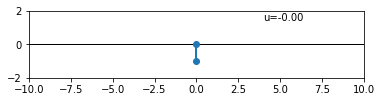

In [18]:
traj2 = ampc.simulate(controller, init_obs=np.array([np.pi, 0.0, 0.0, 0.0]), max_steps=200, dynamics=benchmark.dynamics)

fig = plt.figure()
ax = fig.gca()
anim = benchmark.visualize(fig, ax, traj2)
HTML(anim.to_html5_video())